# Energy Barrier Comparison: CE vs ML Potentials

This notebook visualizes the comparison between Cluster Expansion (CE) and ML potential (CHGNet/MACE) energy barriers.

**Separate analysis for TRAIN and TEST sets to evaluate generalization.**

Run `5_compare_energy_barriers.py` first to generate the data:
```bash
python 5_compare_energy_barriers.py --model chgnet --n_samples 500 --gpu_idx 5
```

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr, pearsonr

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

## 1. Load Results

In [2]:
# Select which model results to load
model_type = 'mace_medium_omat_0'  # or 'mace_medium_omat_0'

results_dir = Path('./comparison_results')
json_file = results_dir / f'barrier_comparison_{model_type}.json'
npz_file = results_dir / f'barrier_data_{model_type}.npz'

# Load JSON for detailed results
with open(json_file, 'r') as f:
    results = json.load(f)

# Load numpy arrays
data = np.load(npz_file)

# Train data
train_ce = data['train_ce_barriers']
train_ml = data['train_ml_barriers']
train_errors = data['train_errors']

# Test data
test_ce = data['test_ce_barriers']
test_ml = data['test_ml_barriers']
test_errors = data['test_errors']

print(f"Loaded results for {model_type}")
print(f"  Train barriers: {len(train_ce)}")
print(f"  Test barriers:  {len(test_ce)}")
print(f"\nConfig:")
for k, v in results['config'].items():
    print(f"  {k}: {v}")

Loaded results for mace_medium_omat_0
  Train barriers: 100
  Test barriers:  100

Config:
  ml_model: mace
  mace_model: medium-omat-0
  n_samples: 100
  seed: 42
  n_atoms: 1512


## 2. Statistics Summary: TRAIN vs TEST

In [3]:
train_stats = results['train_statistics']
test_stats = results['test_statistics']

print("=" * 70)
print("SUMMARY: TRAIN vs TEST")
print("=" * 70)
print(f"{'Metric':<25} {'TRAIN':<20} {'TEST':<20}")
print("-" * 70)
print(f"{'N barriers':<25} {train_stats['n_barriers']:<20} {test_stats['n_barriers']:<20}")
print(f"{'RMSE (meV)':<25} {train_stats['rmse_eV']*1000:<20.2f} {test_stats['rmse_eV']*1000:<20.2f}")
print(f"{'MAE (meV)':<25} {train_stats['mae_eV']*1000:<20.2f} {test_stats['mae_eV']*1000:<20.2f}")
print(f"{'Max error (meV)':<25} {train_stats['max_error_eV']*1000:<20.2f} {test_stats['max_error_eV']*1000:<20.2f}")
print(f"{'Pearson R':<25} {train_stats['pearson_correlation']:<20.4f} {test_stats['pearson_correlation']:<20.4f}")
print(f"{'Spearman R':<25} {train_stats['spearman_correlation']:<20.4f} {test_stats['spearman_correlation']:<20.4f}")
print("=" * 70)

# Generalization check
rmse_ratio = test_stats['rmse_eV'] / train_stats['rmse_eV']
print(f"\nGeneralization (TEST/TRAIN RMSE ratio): {rmse_ratio:.2f}")
if rmse_ratio < 1.2:
    print("  Good generalization (ratio < 1.2)")
elif rmse_ratio < 1.5:
    print("  Moderate overfitting (1.2 < ratio < 1.5)")
else:
    print("  Significant overfitting (ratio > 1.5)")

SUMMARY: TRAIN vs TEST
Metric                    TRAIN                TEST                
----------------------------------------------------------------------
N barriers                100                  100                 
RMSE (meV)                2113.41              1575.44             
MAE (meV)                 1196.09              1189.11             
Max error (meV)           13205.45             4484.18             
Pearson R                 0.6919               0.7790              
Spearman R                0.7477               0.7226              

Generalization (TEST/TRAIN RMSE ratio): 0.75
  Good generalization (ratio < 1.2)


## 3. Parity Plots: TRAIN vs TEST

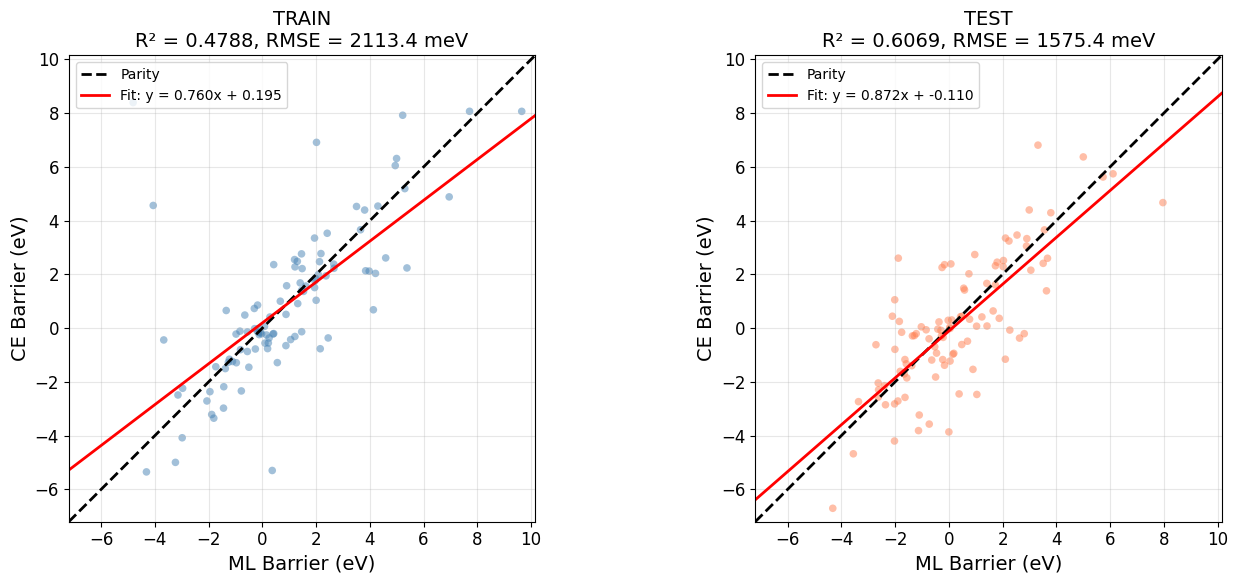

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

datasets = [
    ('TRAIN', train_ml, train_ce, train_stats, 'steelblue'),
    ('TEST', test_ml, test_ce, test_stats, 'coral')
]

# Get common limits
all_ml = np.concatenate([train_ml, test_ml])
all_ce = np.concatenate([train_ce, test_ce])
lims = [min(all_ml.min(), all_ce.min()) - 0.5,
        max(all_ml.max(), all_ce.max()) + 0.5]

for ax, (name, ml, ce, stats, color) in zip(axes, datasets):
    ax.scatter(ml, ce, alpha=0.5, s=30, c=color, edgecolors='none')
    
    # Parity line
    ax.plot(lims, lims, 'k--', lw=2, label='Parity')
    
    # Linear fit
    coeffs = np.polyfit(ml, ce, 1)
    fit_line = np.poly1d(coeffs)
    x_fit = np.linspace(lims[0], lims[1], 100)
    ax.plot(x_fit, fit_line(x_fit), 'r-', lw=2, 
            label=f'Fit: y = {coeffs[0]:.3f}x + {coeffs[1]:.3f}')
    
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel('ML Barrier (eV)', fontsize=14)
    ax.set_ylabel('CE Barrier (eV)', fontsize=14)
    ax.set_title(f'{name}\nR² = {stats["pearson_correlation"]**2:.4f}, '
                 f'RMSE = {stats["rmse_eV"]*1000:.1f} meV', fontsize=14)
    ax.legend(loc='upper left', fontsize=10)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / f'parity_plot_train_test_{model_type}.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Error Distribution: TRAIN vs TEST

/tmp/ipykernel_984554/3715432512.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([train_errors * 1000, test_errors * 1000],


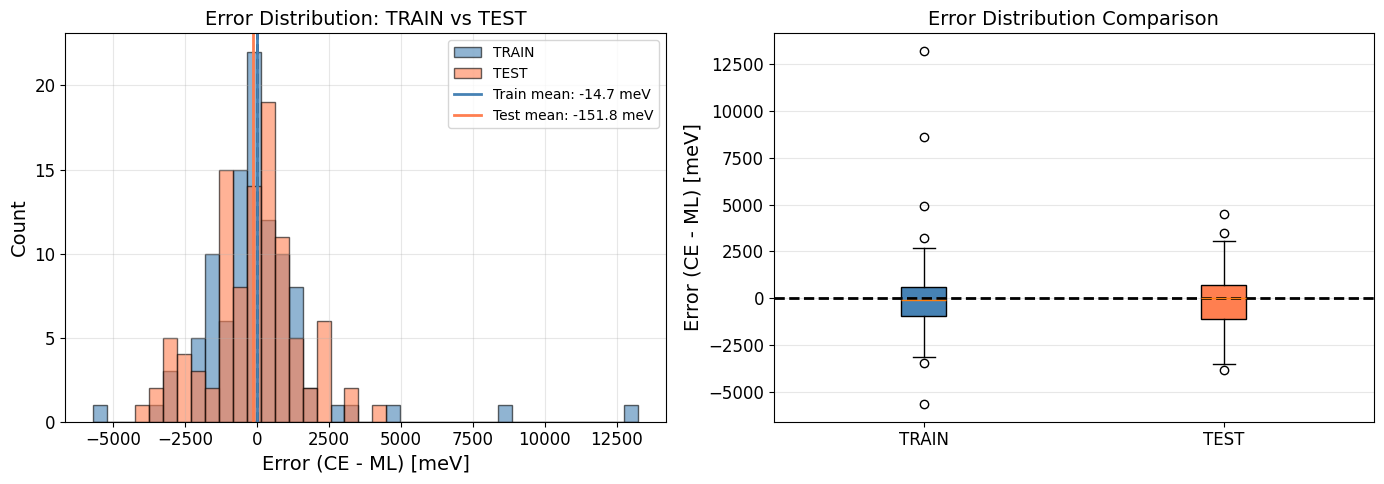

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Combined histogram
ax = axes[0]
bins = np.linspace(
    min(train_errors.min(), test_errors.min()) * 1000 - 50,
    max(train_errors.max(), test_errors.max()) * 1000 + 50,
    40
)

ax.hist(train_errors * 1000, bins=bins, alpha=0.6, label='TRAIN', color='steelblue', edgecolor='black')
ax.hist(test_errors * 1000, bins=bins, alpha=0.6, label='TEST', color='coral', edgecolor='black')
ax.axvline(0, color='black', linestyle='--', lw=2)
ax.axvline(np.mean(train_errors) * 1000, color='steelblue', linestyle='-', lw=2, 
           label=f'Train mean: {np.mean(train_errors)*1000:.1f} meV')
ax.axvline(np.mean(test_errors) * 1000, color='coral', linestyle='-', lw=2,
           label=f'Test mean: {np.mean(test_errors)*1000:.1f} meV')
ax.set_xlabel('Error (CE - ML) [meV]', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Error Distribution: TRAIN vs TEST', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Box plot comparison
ax = axes[1]
bp = ax.boxplot([train_errors * 1000, test_errors * 1000], 
                labels=['TRAIN', 'TEST'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('coral')
ax.axhline(0, color='black', linestyle='--', lw=2)
ax.set_ylabel('Error (CE - ML) [meV]', fontsize=14)
ax.set_title('Error Distribution Comparison', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(results_dir / f'error_distribution_train_test_{model_type}.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Error by Element Type (Train vs Test)

In [6]:
# Group results by dataset and hopping element
def group_by_element(barriers_list):
    by_element = {}
    for item in barriers_list:
        elem = item['atom_symbol']
        if elem not in by_element:
            by_element[elem] = {'ce': [], 'ml': [], 'error': []}
        by_element[elem]['ce'].append(item['ce_barrier'])
        by_element[elem]['ml'].append(item['ml_barrier'])
        by_element[elem]['error'].append(item['error'])
    return by_element

train_barriers = [b for b in results['barriers'] if b['dataset'] == 'train']
test_barriers = [b for b in results['barriers'] if b['dataset'] == 'test']

train_by_elem = group_by_element(train_barriers)
test_by_elem = group_by_element(test_barriers)

# Print statistics by element
print("TRAIN - Statistics by hopping element:")
print("-" * 70)
print(f"{'Element':<10} {'Count':<8} {'MAE (meV)':<12} {'RMSE (meV)':<12} {'Spearman':<10}")
print("-" * 70)

elements = sorted(set(train_by_elem.keys()) | set(test_by_elem.keys()))
for elem in elements:
    if elem in train_by_elem:
        ce = np.array(train_by_elem[elem]['ce'])
        ml = np.array(train_by_elem[elem]['ml'])
        err = np.array(train_by_elem[elem]['error'])
        mae = np.mean(np.abs(err)) * 1000
        rmse = np.sqrt(np.mean(err**2)) * 1000
        sp, _ = spearmanr(ce, ml) if len(ce) > 2 else (0, 1)
        print(f"{elem:<10} {len(ce):<8} {mae:<12.2f} {rmse:<12.2f} {sp:<10.4f}")

print("\nTEST - Statistics by hopping element:")
print("-" * 70)
print(f"{'Element':<10} {'Count':<8} {'MAE (meV)':<12} {'RMSE (meV)':<12} {'Spearman':<10}")
print("-" * 70)

for elem in elements:
    if elem in test_by_elem:
        ce = np.array(test_by_elem[elem]['ce'])
        ml = np.array(test_by_elem[elem]['ml'])
        err = np.array(test_by_elem[elem]['error'])
        mae = np.mean(np.abs(err)) * 1000
        rmse = np.sqrt(np.mean(err**2)) * 1000
        sp, _ = spearmanr(ce, ml) if len(ce) > 2 else (0, 1)
        print(f"{elem:<10} {len(ce):<8} {mae:<12.2f} {rmse:<12.2f} {sp:<10.4f}")

TRAIN - Statistics by hopping element:
----------------------------------------------------------------------
Element    Count    MAE (meV)    RMSE (meV)   Spearman  
----------------------------------------------------------------------
Al         4        4034.70      6682.04      -0.2000   
Co         7        1191.08      1510.30      0.2857    
Cr         12       1890.89      3029.35      0.6643    
Cu         10       1067.85      1509.55      0.8182    
Fe         5        1442.43      1748.14      0.1000    
Ni         7        1696.53      2385.43      0.6429    
O          55       775.93       1079.24      0.9004    

TEST - Statistics by hopping element:
----------------------------------------------------------------------
Element    Count    MAE (meV)    RMSE (meV)   Spearman  
----------------------------------------------------------------------
Al         11       1462.29      1964.06      0.7727    
Co         6        1654.88      2125.48      0.0286    
Cr         

/tmp/ipykernel_984554/1101426371.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(error_data, labels=elements_present, patch_artist=True)
/tmp/ipykernel_984554/1101426371.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(error_data, labels=elements_present, patch_artist=True)


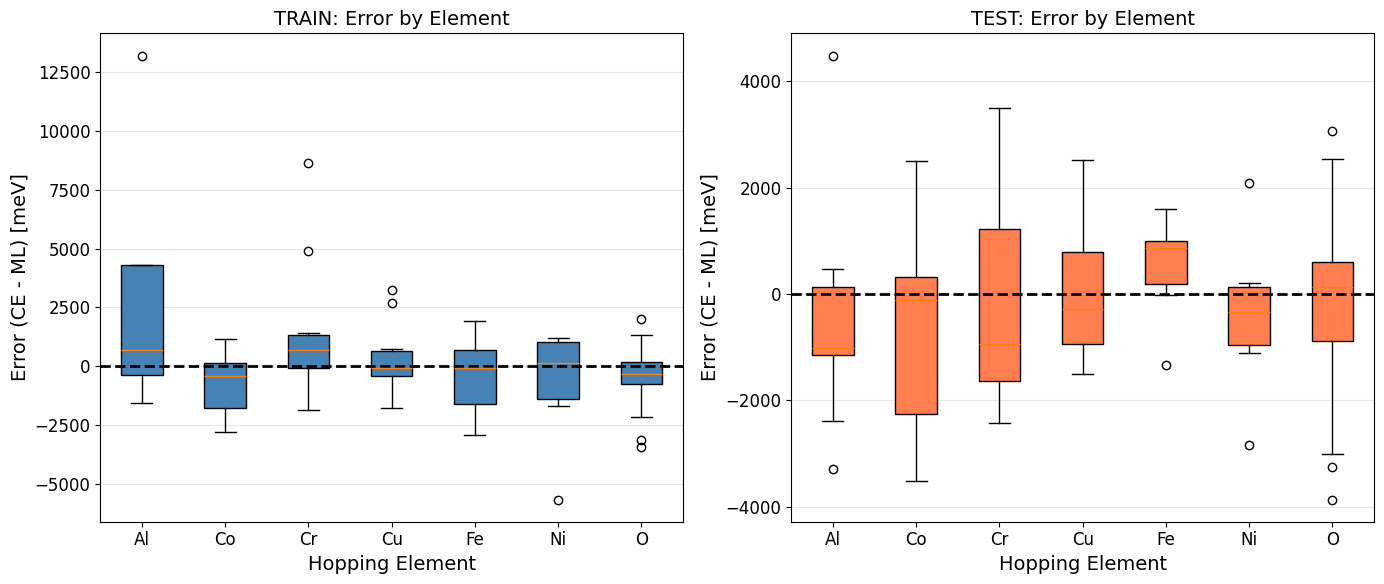

In [7]:
# Box plot by element for Train and Test
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, (name, by_elem, color) in zip(axes, [('TRAIN', train_by_elem, 'steelblue'), 
                                              ('TEST', test_by_elem, 'coral')]):
    elements_present = sorted(by_elem.keys())
    error_data = [np.array(by_elem[elem]['error']) * 1000 for elem in elements_present]
    
    if len(error_data) > 0:
        bp = ax.boxplot(error_data, labels=elements_present, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor(color)
        ax.axhline(0, color='black', linestyle='--', lw=2)
    
    ax.set_xlabel('Hopping Element', fontsize=14)
    ax.set_ylabel('Error (CE - ML) [meV]', fontsize=14)
    ax.set_title(f'{name}: Error by Element', fontsize=14)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(results_dir / f'error_by_element_train_test_{model_type}.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Cumulative Error: TRAIN vs TEST

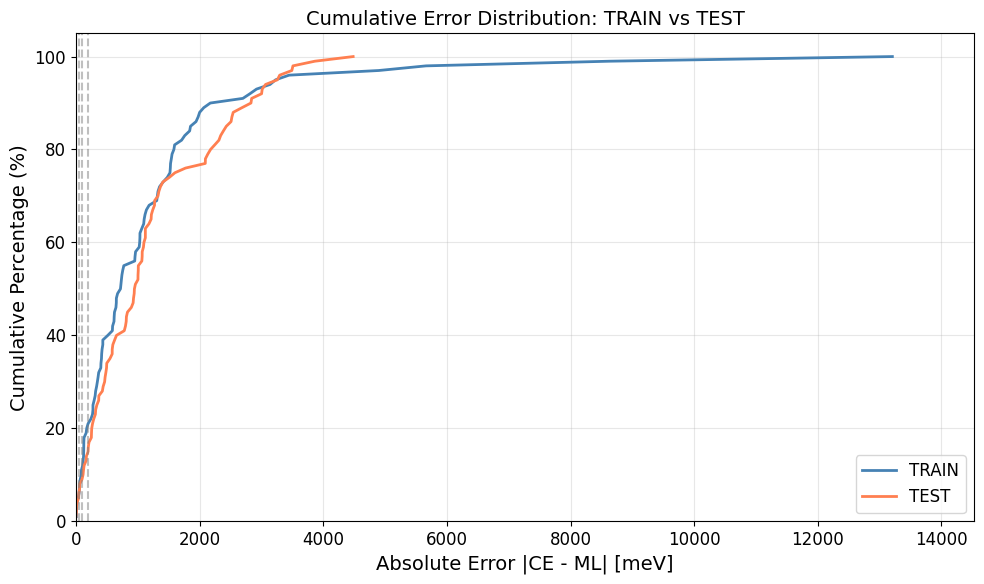

Percentage of samples within error threshold:
Threshold       TRAIN           TEST           
---------------------------------------------
  25 meV         4.0%            4.0%
  50 meV         5.0%            6.0%
 100 meV        11.0%            9.0%
 200 meV        21.0%           15.0%
 500 meV        39.0%           34.0%


In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

for name, errors, color in [('TRAIN', train_errors, 'steelblue'), 
                             ('TEST', test_errors, 'coral')]:
    abs_errors = np.abs(errors) * 1000
    sorted_errors = np.sort(abs_errors)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    ax.plot(sorted_errors, cumulative * 100, lw=2, color=color, label=name)

# Add reference lines
for threshold in [50, 100, 200]:
    ax.axvline(threshold, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Absolute Error |CE - ML| [meV]', fontsize=14)
ax.set_ylabel('Cumulative Percentage (%)', fontsize=14)
ax.set_title('Cumulative Error Distribution: TRAIN vs TEST', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, max(np.abs(train_errors).max(), np.abs(test_errors).max()) * 1000 * 1.1)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig(results_dir / f'cumulative_error_train_test_{model_type}.png', dpi=150, bbox_inches='tight')
plt.show()

# Print percentages
print("Percentage of samples within error threshold:")
print(f"{'Threshold':<15} {'TRAIN':<15} {'TEST':<15}")
print("-" * 45)
for threshold in [25, 50, 100, 200, 500]:
    train_pct = np.mean(np.abs(train_errors) * 1000 <= threshold) * 100
    test_pct = np.mean(np.abs(test_errors) * 1000 <= threshold) * 100
    print(f"{threshold:>4} meV       {train_pct:>5.1f}%          {test_pct:>5.1f}%")

## 7. Summary and Conclusions

In [9]:
print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)
print(f"\nModel comparison: CE vs {model_type.upper()}")
print(f"\nDataset sizes:")
print(f"  TRAIN: {train_stats['n_barriers']} barriers")
print(f"  TEST:  {test_stats['n_barriers']} barriers")

print(f"\n{'='*35}")
print(f"{'Metric':<20} {'TRAIN':<10} {'TEST':<10}")
print(f"{'='*35}")
print(f"{'RMSE (meV)':<20} {train_stats['rmse_eV']*1000:<10.1f} {test_stats['rmse_eV']*1000:<10.1f}")
print(f"{'MAE (meV)':<20} {train_stats['mae_eV']*1000:<10.1f} {test_stats['mae_eV']*1000:<10.1f}")
print(f"{'R²':<20} {train_stats['pearson_correlation']**2:<10.4f} {test_stats['pearson_correlation']**2:<10.4f}")
print(f"{'Spearman R':<20} {train_stats['spearman_correlation']:<10.4f} {test_stats['spearman_correlation']:<10.4f}")

print("\n" + "=" * 70)
print("EVALUATION FOR KMC APPLICATIONS")
print("=" * 70)

# Check generalization
rmse_ratio = test_stats['rmse_eV'] / train_stats['rmse_eV']
print(f"\nGeneralization (TEST/TRAIN RMSE): {rmse_ratio:.2f}x")
if rmse_ratio < 1.2:
    print("  Good generalization")
elif rmse_ratio < 1.5:
    print("  Moderate overfitting - consider more regularization")
else:
    print("  Significant overfitting - need more training data or regularization")

# Check ranking ability (important for KMC)
print(f"\nRanking ability (Spearman on TEST): {test_stats['spearman_correlation']:.4f}")
if test_stats['spearman_correlation'] > 0.9:
    print("  Excellent - CE will rank barriers correctly for KMC")
elif test_stats['spearman_correlation'] > 0.7:
    print("  Good - CE should capture main kinetic trends")
else:
    print("  Poor - CE may miss important kinetic details")

# Check absolute accuracy
print(f"\nAbsolute accuracy (TEST RMSE): {test_stats['rmse_eV']*1000:.1f} meV")
if test_stats['rmse_eV'] < 0.05:
    print("  Excellent - quantitative accuracy for barrier heights")
elif test_stats['rmse_eV'] < 0.1:
    print("  Good - semi-quantitative accuracy")
elif test_stats['rmse_eV'] < 0.3:
    print("  Moderate - qualitative trends should be correct")
else:
    print("  Poor - consider improving CE fitting")

FINAL SUMMARY

Model comparison: CE vs MACE_MEDIUM_OMAT_0

Dataset sizes:
  TRAIN: 100 barriers
  TEST:  100 barriers

Metric               TRAIN      TEST      
RMSE (meV)           2113.4     1575.4    
MAE (meV)            1196.1     1189.1    
R²                   0.4788     0.6069    
Spearman R           0.7477     0.7226    

EVALUATION FOR KMC APPLICATIONS

Generalization (TEST/TRAIN RMSE): 0.75x
  Good generalization

Ranking ability (Spearman on TEST): 0.7226
  Good - CE should capture main kinetic trends

Absolute accuracy (TEST RMSE): 1575.4 meV
  Poor - consider improving CE fitting
